# Višeklasna klasifikacija korišćenjem neuronskih mreža

U ovoj svesci, naš zadatak će biti da napravimo klasfikator koji slici cifre pridružuje cifru koja se na njoj nalazi. Koristićemo poznati MNIST skup slika cifara i pristup koji je baziran na neuronskim mrežama. Koristićemo neuronsku mrežu sa propagacijom unapred, a već na sledećem času, u istom zadatku klasifikacije slika, uvešćemo konvolutivne neuronske mreže koje predstavlju prirodniji izbor. 

In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras import regularizers

In [3]:
np.random.seed(10)

## Korak 1: Učitavanje skupa podataka

MNIST je skup podataka koji sadrži slike rukom pisanih cifara. Slika ima ukupno 70.000 od čega se obično 60.000 slika koristi za treniranje, a preostalih 10.000 za testiranje. Sve slike u skupu podataka su dimenzije 28px x 28px i u crno-belom su modu. Više o MNIST skupu podataka, kao i rezultatima dobijenim prvim algoritmima mašinskog učenja, možete pročitati [ovde](http://yann.lecun.com/exdb/mnist/).

Da bismo učitali MNIST skup podataka iskoristićemo podršku Keras biblioteke preko `mnist.load_data()` funkcije. 

In [4]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

Prva instanca učitanog skupa izgleda ovako.

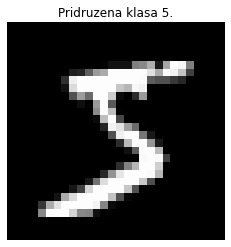

In [5]:
plt.title('Pridruzena klasa {0}.'.format(y_train[0]))
plt.axis('off')
plt.imshow(X_train[0], cmap='gray')
plt.show()

Kao što možemo videti, skup za treniranje sadrži 60.000 instanci formata 28x28.

In [6]:
print(X_train.shape)

(60000, 28, 28)


Skup za testiranje sadrži 10.000 instanci formata 28x28.

In [7]:
print(X_test.shape)

(10000, 28, 28)


## Korak 2: Priprema podataka

Da bismo slike prosledili kao ulaze mreže, transformisaćemo ih u vektore dužine 28x28=784.

In [8]:
image_size = X_train.shape[1]

In [9]:
X_train = X_train.reshape(X_train.shape[0], image_size*image_size)
X_test = X_test.reshape(X_test.shape[0], image_size*image_size)

In [10]:
print(X_train.shape)

(60000, 784)


In [11]:
print(X_test.shape)

(10000, 784)


Slike ćemo pripremiti tako što ćemo ih normalizovati, tj. svesti vrednosti pojedinačnih piksela na vrednost iz intervala iz [0, 1]. Prethodno ćemo promeniti tip elemenata matrice sa *uint8* na *float32* kako bi mogli da sačuvamo realne vrednosti.

In [12]:
X_train.dtype

dtype('uint8')

In [13]:
X_train = X_train.astype('float32')
X_train /= 255

In [14]:
X_test = X_test.astype('float32')
X_test /= 255

Kao što smo videli, vrednosti ciljne promenljive su brojevi od 0 od 9. Uvid u brojnost instanci po klasama možemo dobiti na osnovu sledećeg grafika.

In [15]:
classes = np.unique(y_train)

In [16]:
classes

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

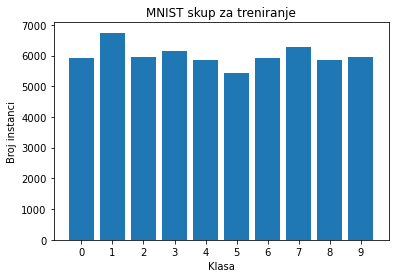

In [17]:
plt.xlabel('Klasa')
plt.ylabel('Broj instanci')
plt.title ('MNIST skup za treniranje')

plt.xticks(classes)

plt.bar(classes, np.bincount(y_train))
plt.show()

Vrednosti ciljne promenljive ćemo pripremiti tako što ćemo ih transformisati u vektore dužine 10 sa jedinicom na poziciji koja odgovara vrednosti cifre (takozvano *one-hot* kodiranje). Na primer, broj 3 će biti transformisan u vektor \[0, 0, 0, 1, 0, 0, 0, 0, 0, 0\] sa jedinicom na poziciji tri. 

Za ovu transformaciju iskoristićemo funkciju `to_categorical` paketa `keras.utils`.

In [18]:
number_of_classes = classes.shape[0]

y_train = keras.utils.to_categorical(y_train, number_of_classes)
y_test = keras.utils.to_categorical(y_test, number_of_classes)

In [19]:
print(y_train.shape)

(60000, 10)


Na primer, prvoj instanci skupa za treniranje, cifri 5, je sada pridružen vektor:

In [20]:
y_train[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

## Korak 3: Pravljenje modela

Na slici je prikazana arhitekture mreže koju ćemo kreirati. 

<img src="assets/mlp_mnist.png" />

#### Ulazni sloj

Ulaz u mrežu je "ispravljena" slika dimenzije 784 piksela.

<img src="assets/mnist-input.png" />


#### Skriveni slojevi

Mreža ima dva skrivena sloja, jedan dimenzije 128 neurona i drugi dimenzije 64 neurona. Oba sloja kao aktivaciju koriste *ReLu* funkciju.



#### Izlazni sloj

Izlazni sloj mreže ima 10 neurona. Svaki od njih odgovara jednoj od cifara od 0 do 9. Ideja je da vrednosti izlaza predstavljaju verovatnoće pripadanja odgovarajućoj klasi cifara. Preciznije, ako se za ulaz *img* koji predstavlja sliku dobija izlaz oblika $(v_0, v_1, v_2, v_3, v_4, v_5, v_6, v_7, v_8, v_9)$ rezultat tj. klasa pripadanja će biti ona vrednost $i$ za koju je $v_i$ maksimalno. Na primer, ako $v_4$ ima najveću vrednost, onda zaključujemo da slika *img*  predstavlja broj 4. 

Zato ćemo u poslednjem sloju mreže kao aktivacionu funkciju iskoristiti funkciju mekog maksimuma (engl. softmax) koja vrednost $v_i$ mapira u vrednost $\frac{e^{v_i}}{\sum_j{e^{v_j}}}$

In [21]:
model = Sequential([
    InputLayer(input_shape=(image_size*image_size,)),
    Dense(units=128, activation='relu'), 
    Dense(units=64, activation='relu'),
    Dense(units=number_of_classes, activation='softmax')
])

Model možemo kontrolno prikazati pozivom metode `summary`.

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                650       
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_________________________________________________________________


U zadacima višeklasne klasifikacije, uz aktivaciju mekog maksimuma u zadanjem sloju, obično se kao funkcija gubitka koristi `kategorička unakrsna entropija` (engl. categorical crossentropy). Ona predstavlja uopštenje binarne unakrsne entropije i računa se po formuli $-\sum_i{y_i \cdot log(\hat{y_i})}$ u kojoj $\hat{y_i}$ predstavlja predikciju mreže za instacu $i$, a $y_i$ njenu stvarnu vrednost. 

Kao optimizator ćemo koristiti `Adam`. 

Pratićemo tačnost kao relevantnu metriku za ocenu klasifikacije.

In [23]:
model.compile(loss=CategoricalCrossentropy(), optimizer=Adam(lr=0.001), metrics=['accuracy'])

Mrežu ćemo trenirati u 30 epoha korišćenjem paketića veličine 128 instanci. Jedan deo podataka iskoristićemo za validaciju. Njegovu veličinu naglasićemo parametrom `validation_split`. 

In [24]:
batch_size = 128
epochs = 30

In [25]:
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.2)

Epoch 1/30
375/375 [==============================] - 1s 4ms/step - loss: 0.3637 - accuracy: 0.8979 - val_loss: 0.1754 - val_accuracy: 0.9492
Epoch 2/30
375/375 [==============================] - 1s 3ms/step - loss: 0.1492 - accuracy: 0.9563 - val_loss: 0.1328 - val_accuracy: 0.9603
Epoch 3/30
375/375 [==============================] - 1s 3ms/step - loss: 0.1049 - accuracy: 0.9689 - val_loss: 0.1010 - val_accuracy: 0.9701
Epoch 4/30
375/375 [==============================] - 1s 3ms/step - loss: 0.0773 - accuracy: 0.9770 - val_loss: 0.1060 - val_accuracy: 0.9691
Epoch 5/30
375/375 [==============================] - 1s 3ms/step - loss: 0.0602 - accuracy: 0.9822 - val_loss: 0.0973 - val_accuracy: 0.9699
Epoch 6/30
375/375 [==============================] - 1s 3ms/step - loss: 0.0474 - accuracy: 0.9857 - val_loss: 0.1028 - val_accuracy: 0.9691
Epoch 7/30
375/375 [==============================] - 1s 3ms/step - loss: 0.0381 - accuracy: 0.9888 - val_loss: 0.0905 - val_accuracy: 0.9748
Epoch 

Možemo nacrtati i grafike funkcije gubitka i tačnosti u toku treniranja koristeći i skup za treniranje i skup za validaciju.  

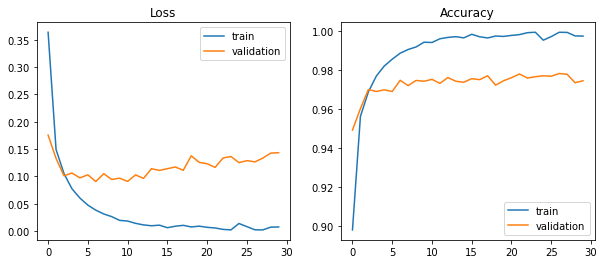

In [26]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(np.arange(0, epochs), history.history['loss'], label='train')
plt.plot(np.arange(0, epochs), history.history['val_loss'], label='validation')
plt.legend(loc='best')


plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(np.arange(0, epochs), history.history['accuracy'], label='train')
plt.plot(np.arange(0, epochs), history.history['val_accuracy'], label='validation')
plt.legend(loc='best')

plt.show()

Iz grafika funkcije greške zaključujemo da dolazi do preprilagođavanja modela. 

U opštem slučaju, prilikom analize tačnosti klasifikacije možemo se voditi zaključcima prikazanim na slici. <img src='assets/train_val_accuracy.png'>

Jedan način da se doda regularizacija modelu je uz korišćenje L2 regularizacije na nivou slojeva mreže.

In [27]:
regularizer = regularizers.l2(l=0.01)

In [28]:
model_with_regularization = Sequential([
    InputLayer(input_shape=(image_size*image_size,)),
    Dense(units=128, activation='relu', kernel_regularizer=regularizer), 
    Dense(units=64, activation='relu', kernel_regularizer=regularizer),
    Dense(units=number_of_classes, activation='softmax')
])

In [29]:
model_with_regularization.compile(loss=CategoricalCrossentropy(), optimizer=Adam(lr=0.001), metrics=['accuracy'])

In [30]:
history_with_regularization = model_with_regularization.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.2)

Epoch 1/30
375/375 [==============================] - 2s 6ms/step - loss: 1.2470 - accuracy: 0.8753 - val_loss: 0.6514 - val_accuracy: 0.9195
Epoch 2/30
375/375 [==============================] - 2s 4ms/step - loss: 0.5973 - accuracy: 0.9164 - val_loss: 0.5261 - val_accuracy: 0.9301
Epoch 3/30
375/375 [==============================] - 2s 4ms/step - loss: 0.5226 - accuracy: 0.9257 - val_loss: 0.4908 - val_accuracy: 0.9289
Epoch 4/30
375/375 [==============================] - 1s 4ms/step - loss: 0.4842 - accuracy: 0.9296 - val_loss: 0.4458 - val_accuracy: 0.9417
Epoch 5/30
375/375 [==============================] - 1s 4ms/step - loss: 0.4551 - accuracy: 0.9351 - val_loss: 0.4522 - val_accuracy: 0.9342
Epoch 6/30
375/375 [==============================] - 1s 4ms/step - loss: 0.4338 - accuracy: 0.9375 - val_loss: 0.4087 - val_accuracy: 0.9480
Epoch 7/30
375/375 [==============================] - 1s 3ms/step - loss: 0.4135 - accuracy: 0.9421 - val_loss: 0.3971 - val_accuracy: 0.9470
Epoch 

Nacrtaćemo ponovo grafike funkcije gubitka i funkcije tačnosti. 

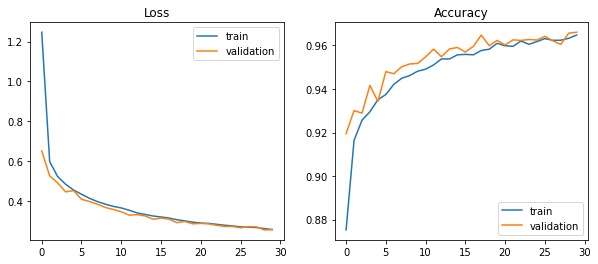

In [31]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(np.arange(0, epochs), history_with_regularization.history['loss'], label='train')
plt.plot(np.arange(0, epochs), history_with_regularization.history['val_loss'], label='validation')
plt.legend(loc='best')


plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(np.arange(0, epochs), history_with_regularization.history['accuracy'], label='train')
plt.plot(np.arange(0, epochs), history_with_regularization.history['val_accuracy'], label='validation')
plt.legend(loc='best')

plt.show()

Kao što možemo videti sada se situacija značajno popravila i naše krive se lepo prate. 

Zbog velikog broja parametara, regularizacije se gotovo pa neizostavno koriste u procesu obučavanja neuronskih mreža. Još jedna tehnika regularizacije je takozvana `dropout` regularizacija. Korišćenjem `dropout` regularizacije isključujemo nasumično odabrane neurone, omogućavamo drugačiji protok podataka kroz mrežu i smanjujemo zavisnosti izlaza od ulaza. Da bi se primenila ova tehnika regularizacije, dovoljno je mreži dodati `Dropout` sloj. Njegov parametar `rate` je verovatnoća isključivanja pojedinačnih neurona.
<img src='assets/dropout.png'>

In [32]:
model_with_droupout = Sequential([
    InputLayer(input_shape=(image_size*image_size,)),
    Dense(units=128, activation='relu'), 
    Dropout(rate=0.4),
    Dense(units=64, activation='relu'),
    Dropout(rate=0.3),
    Dense(units=number_of_classes, activation='softmax')
])

In [33]:
model_with_droupout.compile(loss=CategoricalCrossentropy(), optimizer=Adam(lr=0.001), metrics=['accuracy'])

In [34]:
history_with_dropout = model_with_droupout.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.2)

Epoch 1/30
375/375 [==============================] - 1s 3ms/step - loss: 0.6201 - accuracy: 0.8077 - val_loss: 0.2192 - val_accuracy: 0.9354
Epoch 2/30
375/375 [==============================] - 1s 3ms/step - loss: 0.3000 - accuracy: 0.9137 - val_loss: 0.1644 - val_accuracy: 0.9527
Epoch 3/30
375/375 [==============================] - 1s 3ms/step - loss: 0.2364 - accuracy: 0.9311 - val_loss: 0.1389 - val_accuracy: 0.9600
Epoch 4/30
375/375 [==============================] - 1s 3ms/step - loss: 0.2040 - accuracy: 0.9397 - val_loss: 0.1219 - val_accuracy: 0.9651
Epoch 5/30
375/375 [==============================] - 1s 3ms/step - loss: 0.1781 - accuracy: 0.9474 - val_loss: 0.1124 - val_accuracy: 0.9679
Epoch 6/30
375/375 [==============================] - 1s 3ms/step - loss: 0.1635 - accuracy: 0.9514 - val_loss: 0.1072 - val_accuracy: 0.9698
Epoch 7/30
375/375 [==============================] - 1s 3ms/step - loss: 0.1487 - accuracy: 0.9555 - val_loss: 0.0999 - val_accuracy: 0.9712
Epoch 

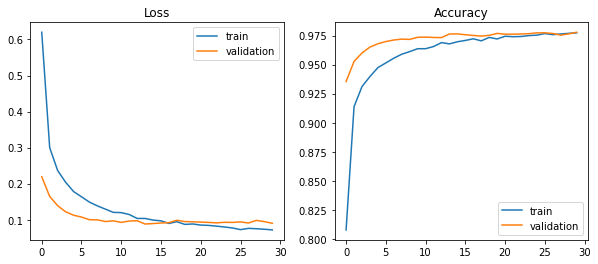

In [35]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(np.arange(0, epochs), history_with_dropout.history['loss'], label='train')
plt.plot(np.arange(0, epochs), history_with_dropout.history['val_loss'], label='validation')
plt.legend(loc='best')


plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(np.arange(0, epochs), history_with_dropout.history['accuracy'], label='train')
plt.plot(np.arange(0, epochs), history_with_dropout.history['val_accuracy'], label='validation')
plt.legend(loc='best')

plt.show()

Primetimo da je na ovaj način dobijena manja vrednost funkcije gubitka i nešto veća tačnost u odnosu na prethodni vid regularizacie.

### Korak 4: Evaluacija modela

Model ćemo oceniti na skupu za testiranje.

In [36]:
score = model_with_droupout.evaluate(X_test, y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 0s 1ms/step - loss: 0.0789 - accuracy: 0.9793
Test loss: 0.07893338054418564
Test accuracy: 0.9793000221252441


Vrednosti koje smo očitali iz promenljive `score` su usklađene sa imenima metrika koje su korišćene:

In [37]:
model_with_droupout.metrics_names

['loss', 'accuracy']

### Korak 5: Analiza prostora grešaka

Videli smo da model daje dobru ocenu tačnosti. U praksi je značajno izdvojiti i instance na kojima model ne radi dobro u cilju boljeg razumevanja njegovog rada i budućih popravki.

Kreiraćemo prvo niz sa predikcijama modela.

In [38]:
y_predictions = model_with_droupout.predict(X_test)

Možemo nacrtati, na primer, prvih 20 instanci test skupa i obeležja koja im pridružuje klasifikator. 

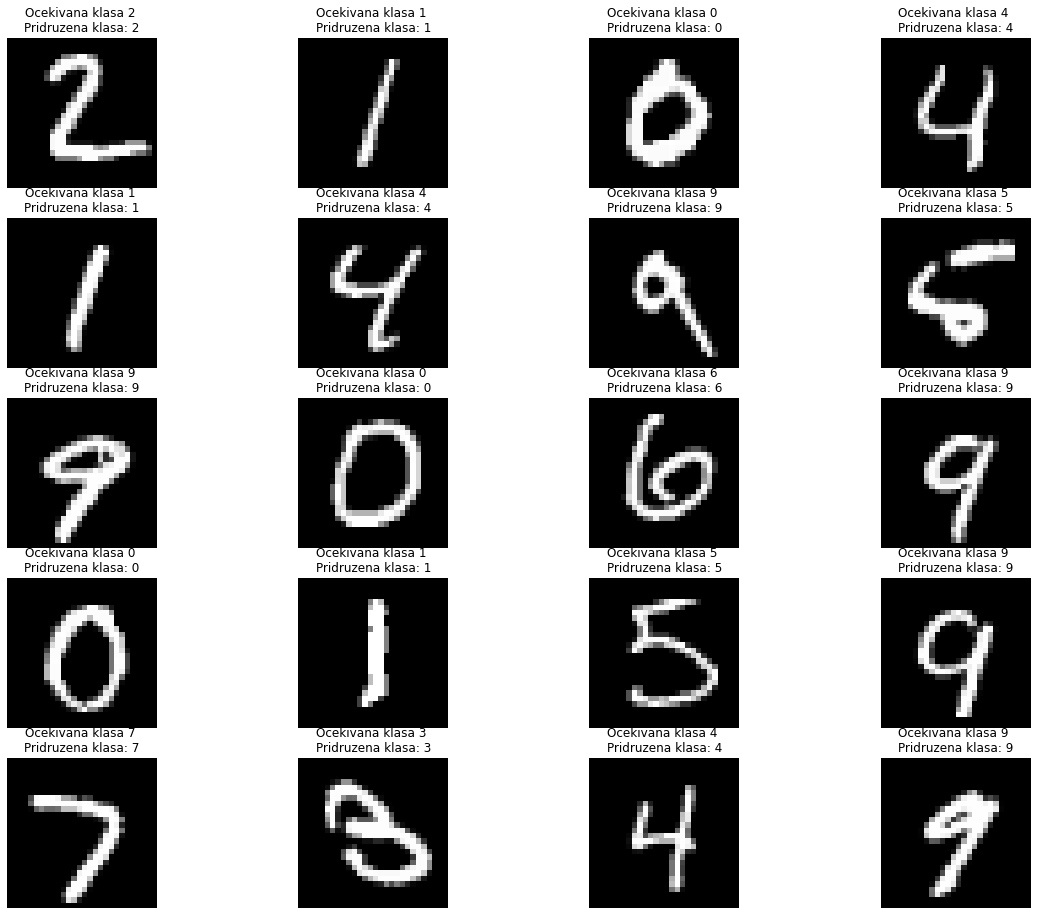

In [39]:
fig = plt.figure(figsize=(20, 16))
columns = 4
rows = 5
for i in range(1, rows*columns +1):
    # kreiramo blok u okviru kojeg ćemo prikazati sliku
    fig.add_subplot(rows, columns, i)

    # dohvatamo odgovarajući vektor slike i transformišemo ga u 2D sliku dimenzija 28x28
    img = X_test[i].reshape(image_size, image_size)
    
    # postavljamo u bloku naslov koji sadrzi tacnu vrednosti i predviđenu vrednosti
    true_label = np.argmax(y_test[i])
    predicted_label = np.argmax(y_predictions[i])
    plt.title('Ocekivana klasa {0} \nPridruzena klasa: {1}'.format(true_label, predicted_label))
    plt.axis('off')
    
    # prikazujemo sliku
    plt.imshow(img, cmap='gray')
    
plt.show()

Vidimo da su sve izdvojene slike dobro klasifikovane. 

Sada ćemo pronaći one slike kod kojih se stvarna obeležja i predikcije razlikuju. Za pronalaženje obeležja iskoristićemo funkciju `np.argmax` koja pronalazi poziciju maksimalne vrednosti u nizu, a koja se uklapa u reprezentacije dobijene primenom aktivacije mekog maksimuma za predikcije.

In [40]:
y_predictions[0]

array([5.9660797e-11, 1.1112693e-10, 4.2236348e-07, 2.2261420e-06,
       4.3198997e-13, 2.7604510e-10, 2.7753564e-16, 9.9999726e-01,
       2.1037576e-09, 2.4079492e-08], dtype=float32)

In [41]:
np.argmax(y_predictions[0])

7

In [42]:
predicted_labels = np.argmax(y_predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)
error_indexes = np.where(predicted_labels != true_labels)[0]

Broj instanci koje je klasifikator pogrešno klasifikovao:

In [43]:
number_of_errors = len(error_indexes)
number_of_errors

207

Prikazaćemo neku od slika sa pogrešnom labelom.

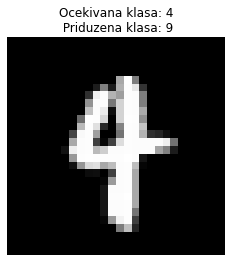

In [44]:
error_index = np.random.choice(error_indexes)
true_label = true_labels[error_index]
predicted_label = predicted_labels[error_index]

plt.title("Ocekivana klasa: {0}\n Priduzena klasa: {1}".format(true_label, predicted_label))
plt.imshow(X_test[error_index].reshape(image_size, image_size), cmap='gray')
plt.axis('off')
plt.show()

### Korak 6: Finalni model

Mreža se sada može istrenirati na celom skupu za učenje, a zatim i oceniti na skupu za testiranje. U praksi se ipak, zbog veličine skupova podataka i zahtevnosti treniranja, za finalni model proglašava model obučen na skupu za treniranje.

In [45]:
model_final = Sequential([
    InputLayer(input_shape=(image_size*image_size,)),
    Dense(units=128, activation='relu'), 
    Dropout(rate=0.4),
    Dense(units=64, activation='relu'),
    Dropout(rate=0.3),
    Dense(units=number_of_classes, activation='softmax')
])

In [46]:
model_final.compile(loss=CategoricalCrossentropy(), optimizer=Adam(lr=0.001), metrics=['accuracy'])

In [47]:
history_final = model_final.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1)

Epoch 1/30
469/469 [==============================] - 1s 3ms/step - loss: 0.5628 - accuracy: 0.8267
Epoch 2/30
469/469 [==============================] - 1s 3ms/step - loss: 0.2648 - accuracy: 0.9230
Epoch 3/30
469/469 [==============================] - 1s 3ms/step - loss: 0.2091 - accuracy: 0.9399
Epoch 4/30
469/469 [==============================] - 1s 3ms/step - loss: 0.1804 - accuracy: 0.9478
Epoch 5/30
469/469 [==============================] - 1s 3ms/step - loss: 0.1626 - accuracy: 0.9519
Epoch 6/30
469/469 [==============================] - 1s 3ms/step - loss: 0.1483 - accuracy: 0.9567: 0s - loss: 0.1487 - accuracy: 0.
Epoch 7/30
469/469 [==============================] - 1s 3ms/step - loss: 0.1389 - accuracy: 0.9580
Epoch 8/30
469/469 [==============================] - 1s 3ms/step - loss: 0.1308 - accuracy: 0.9614
Epoch 9/30
469/469 [==============================] - 1s 3ms/step - loss: 0.1214 - accuracy: 0.9642
Epoch 10/30
469/469 [==============================] - 1s 3ms/step

In [48]:
test_loss, test_accuracy = model_final.evaluate(X_test, y_test)
print ("Test loss: {}, test accuracy: {}".format(test_loss, test_accuracy))

313/313 [==============================] - 0s 1ms/step - loss: 0.0792 - accuracy: 0.9791
Test loss: 0.0791643038392067, test accuracy: 0.9790999889373779


In [49]:
train_loss, train_accuracy = model_final.evaluate(X_train, y_train)
print ("Train loss: {}, train accuracy: {}".format(train_loss, train_accuracy))

1875/1875 [==============================] - 3s 1ms/step - loss: 0.0168 - accuracy: 0.9950
Train loss: 0.01684248447418213, train accuracy: 0.9949666857719421
